# K2SC Lightkurve Interface

Let's go through how you would use `k2sc` with its `lightkurve` interface to detrend the light curve of WASP-55. First, we import some things!

In [1]:
import numpy as np
import matplotlib 
import matplotlib as mpl

import lightkurve  as lk

import k2sc
from k2sc.standalone import k2sc_lc

from astropy.io import fits

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.filterwarnings('ignore')

print(lk.__version__)
print(k2sc.__version__)

Populating the interactive namespace from numpy and matplotlib
2.0.11.to_fits
1.0.1.4


### Reading in data.

Let's search MAST for the long-cadence light curve file of WASP-55 using the `lightkurve` API, and do some very basic filtering for data quality.

In [2]:
lc = lk.search_lightcurve('EPIC 212300977')[1].download()
lc = lc.remove_nans()
lc = lc[lc.quality==0]

### Let's now try K2SC!

As a quick hack for now, let's just clobber the `lightkurve` object class to our `k2sc` standalone.

In [3]:
lc.__class__ = k2sc_lc

Now we run with default values!

The `tqdm` progress bar will show a percentage of the maximum iterations of the differential evolution optimizer, but it will usually finish early.

In [4]:
lc.k2sc()

Using default splits [2390, 2428] for campaign 6


  0%|          | 0/150 [00:00<?, ?it/s]

Starting initial outlier detection
  Flagged 114 ( 3.6%) outliers.
Starting Lomb-Scargle period search
  Using SqrExp position kernel
  Found periodicity p =   14.34 (fap 2.5446e-54 < 1e-50), will use a quasiperiodic kernel
Starting global hyperparameter optimisation using DE


 69%|██████▊   | 103/150 [04:44<02:09,  2.76s/it, -ln(L)=-5062.4]


  DE finished in 284 seconds
  DE minimum found at: [-5.999e+00  9.686e-01  1.081e+01  8.653e-03 -5.095e+00  2.448e+01  1.111e+01 -3.460e+00]
  DE -ln(L) -5062.4
Starting local hyperparameter optimisation
  Local minimum found at: [-6.000e+00  9.681e-01  1.092e+01  9.137e-03 -5.062e+00  2.442e+01
  1.061e+01 -3.458e+00]
Starting final outlier detection
      5 too high
     80 too low
      0 not finite
Computing time and position trends
  CDPP - raw - 211.404
  CDPP - position component removed - 59.007
  CDPP - full reduction - 59.014
Detrending time 290.7708077430725


Now we plot! See how the `k2sc` lightcurve has such better quality than the uncorrected data.

Careful with `astropy` units - flux and time are dimensionful quantities in `lightkurve` 2.0, so we have to use `.value` to render them as numbers.

Text(0.5, 1.01, 'WASP-55')

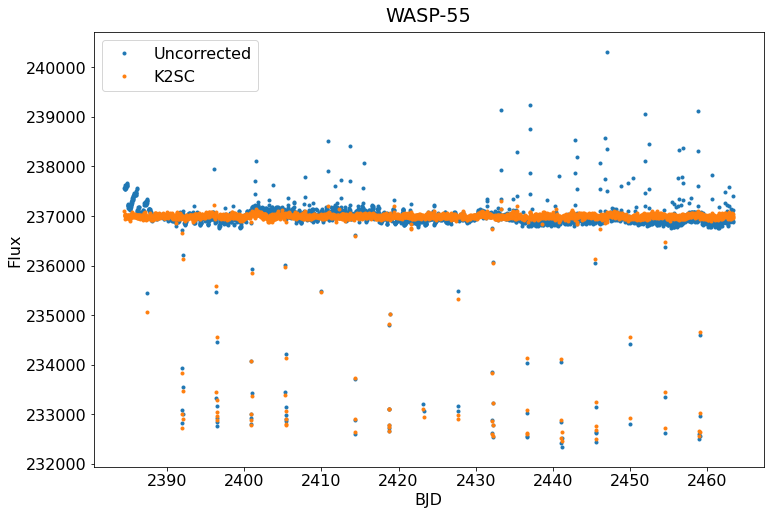

In [5]:
fig = plt.figure(figsize=(12.0,8.0))
plt.plot(lc.time.value,lc.flux.value,'.',label="Uncorrected")
detrended = lc.corr_flux-lc.tr_time + np.nanmedian(lc.tr_time)
plt.plot(lc.time.value,detrended.value,'.',label="K2SC")
plt.legend()
plt.xlabel('BJD')
plt.ylabel('Flux')
plt.title('WASP-55',y=1.01)

### Now we save the data.

In [6]:
extras = {'CORR_FLUX':lc.corr_flux.value,
          'TR_TIME':lc.tr_time.value,
          'TR_POSITION':lc.tr_position.value}
out = lc.to_fits(extra_data=extras,path='test.fits',overwrite=True)